---
date: 12-12-2023
author: Martin Proks
title: 09 - Classification explanation
---

Looks like all the classifiers have their own internal genes for prediction.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1,2'

In [61]:
import warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=UserWarning)

import anndata
import shap
import scvi
import scgen
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from upsetplot import UpSet, from_contents, plot
from matplotlib_venn import venn3

scvi.settings.seed = 0


def train_test_group_split(adata: anndata.AnnData, groupby: str):
    """
    Function to split anndata object 80/20 per group in format
    required for SCANVIDeep explainer.
    """
    import torch
    groups = adata.obs.groupby(groupby)
    train, test = [], []
    for _, cells in groups.groups.items():
        train_test = train_test_split(cells.values, test_size=0.1)
        
        train.append(train_test[0])
        test.append(train_test[1])

    train, test = np.concatenate(train), np.concatenate(test)
    
    X_train = {
        'X': torch.from_numpy(adata[train].layers['counts'].A).type(torch.DoubleTensor),
        'batch': torch.from_numpy(adata[train].obs.batch.cat.codes.values[:, np.newaxis]),
        'labels': torch.from_numpy(adata[train].obs.ct.cat.codes.values[:, np.newaxis])
    }

    X_test = {
        'X': torch.from_numpy(adata[test].layers['counts'].A).type(torch.DoubleTensor),
        'batch': torch.from_numpy(adata[test].obs.batch.cat.codes.values[:, np.newaxis]),
        'labels': torch.from_numpy(adata[test].obs.ct.cat.codes.values[:, np.newaxis])
    }
    
    return train, X_train, test, X_test

[rank: 0] Global seed set to 0


In [3]:
%run ../scripts/deep_scanvi.py

In [4]:
mouse = anndata.read_h5ad("../results/03_mouse.processed.h5ad")
background_idx, background, test_idx, test = train_test_group_split(mouse, groupby='ct')

## 1. scANVI

In [102]:
def get_shap_feature(adata, shaps, clf_name: str):
    result = []
    
    for idx, ct in enumerate(adata.obs.ct.cat.categories):
        vals = pd.DataFrame(shaps[idx], index=adata.obs_names, columns=adata.var_names)
        vals['ct'] = adata.obs.ct.cat.codes.values
        vals = vals.query('ct == @idx').iloc[:, :-1]
        
        weights = vals\
            .mean(axis=0)\
            .sort_values(ascending=False)\
            .reset_index()\
            .rename(columns={'index':'feature',0:'weight'})
            # .query('weight > 0.5')
        
        weights['ct'] = adata.obs.ct.cat.categories[idx]
        result.append(weights)
    
    result = pd.concat(result)
    result['clf'] = clf_name
    
    return result

In [103]:
lvae = scvi.model.SCANVI.load("../results/02_mouse_integration/scanvi_ns_15/")

INFO     File ../results/02_mouse_integration/scanvi_ns_15/model.pt already downloaded                             


In [ ]:
shap_values = SCANVIDeep(lvae.module, background).shap_values(test)

 33%|███████████████████████████▋                                                       | 5/15 [04:18<08:41, 52.10s/it]

In [ ]:
# shap.summary_plot(shap_values, test['X'], feature_names=FEATURES, class_names=CATEGORIES)

In [105]:
shap_scANVI = get_shap_feature(mouse[test_idx], shap_values, 'scANVI')

In [106]:
shap_scANVI

,feature,weight,ct,clf
0,oosp1,16.723852,Zygote,scANVI
1,e330021d16rik,16.723083,Zygote,scANVI
2,btg4,15.874923,Zygote,scANVI
3,zbed3,15.021937,Zygote,scANVI
4,e330034g19rik,14.736804,Zygote,scANVI
...,...,...,...,...
2995,cst3,-0.025896,E4.5-PrE,scANVI
2996,gpx2,-0.030260,E4.5-PrE,scANVI
2997,glipr1,-0.044704,E4.5-PrE,scANVI
2998,cyp4f14,-0.047850,E4.5-PrE,scANVI


## 2. XGBoost

In [ ]:
def get_shap_features_from_explainer(adata, shaps, clf_name: str):
    
    result = []
    for idx, ct in enumerate(adata.obs.ct.cat.categories):
        vals = pd.DataFrame(shaps[:, :, idx].values, index=adata.obs_names, columns=adata.var_names)
        vals['ct'] = adata.obs.ct.cat.codes.values
        vals = vals.query('ct == @idx').iloc[:, :-1]
        
        weights = vals\
            .mean(axis=0)\
            .sort_values(ascending=False)\
            .reset_index()\
            .rename(columns={'index':'feature',0:'weight'})
            # .query('weight > 0.5')
        
        weights['ct'] = adata.obs.ct.cat.categories[idx]
        result.append(weights)

    result = pd.concat(result)
    result['clf'] = clf_name
    
    return result

### 2.1. scVI

In [ ]:
vae = scvi.model.SCVI.load("../results/02_mouse_integration/scvi")
xg_clf = xgb.XGBClassifier()
xg_clf.load_model("../results/05_scVI_xgboost.json")

shap_values = shap.GPUTreeExplainer(xg_clf)(vae.get_normalized_expression(return_mean=True).values, check_additivity=False)
shap_xg_scVI = get_shap_features_from_explainer(mouse, shap_values, 'xg_scVI')

### 2.2. scANVI

In [ ]:
lvae = scvi.model.SCANVI.load("../results/02_mouse_integration/scanvi/")
xg_clf = xgb.XGBClassifier()
xg_clf.load_model("../results/05_scANVI_xgboost.json")

shap_values = shap.GPUTreeExplainer(xg_clf)(lvae.get_normalized_expression(return_mean=True).values, check_additivity=False)
shap_xg_scANVI = get_shap_features_from_explainer(mouse, shap_values, 'xg_scANVI')

### 2.3. scGEN

In [ ]:
mscgen = scgen.SCGEN.load("../results/02_mouse_integration/scgen/")
xg_clf = xgb.XGBClassifier()
xg_clf.load_model("../results/05_scGEN_xgboost.json")

shap_values = shap.GPUTreeExplainer(xg_clf)(mscgen.get_decoded_expression(), check_additivity=False)
shap_xg_scGEN = get_shap_features_from_explainer(mouse, shap_values, 'xg_scGEN')

In [ ]:
# xg_clfs = pd.concat([shap_scANVI, shap_xg_scVI, shap_xg_scANVI, shap_xg_scGEN], ignore_index=True)
# xg_clfs.to_feather("../results/09_clf.feather")
# xg_clfs

In [ ]:
xg_clfs = pd.read_feather("../results/09_clf.feather")

In [ ]:
pos = xg_clfs.query('weight > 0').groupby('clf')['feature'].apply(set).to_dict()
neg = xg_clfs.query('weight < 0').groupby('clf')['feature'].apply(set).to_dict()

In [ ]:
fig = plt.figure(figsize=(10, 4))
fig.suptitle('Positive weights')
_ = plot(from_contents(pos), fig=fig, element_size=None, show_counts=True)

fig = plt.figure(figsize=(10, 4))
fig.suptitle('Negative weights')
_ = plot(from_contents(neg), fig=fig, element_size=None, show_counts=True)

## Comparisons

In [130]:
def run_clf_scanvi(clf, adata, clf_name: str, n: int=10) -> pd.DataFrame:
    results = []
    
    for i in tqdm(range(n)):
        background_idx, background, test_idx, test = train_test_group_split(adata, groupby='ct')
        shap_values = SCANVIDeep(clf.module, background).shap_values(test)
        weights = get_shap_feature(mouse[test_idx], shap_values, 'scANVI')
        weights['iteration'] = i + 1
        results.append(weights)
    res = pd.concat(results)

    res_means = pd.DataFrame(res.query('weight > 0').groupby(['ct', 'feature']).weight.mean())
    res_means['n'] = res.query('weight > 0').groupby(['ct', 'feature']).count().loc[res_means.index, 'iteration']
    res_means = res_means.query('n == @n')
    res_th = res.query('weight > 0').groupby(['clf', 'ct']).weight.quantile(0.9).unstack().T
    res_means = pd.merge(res_means.reset_index(), res_th, left_on='ct', right_index=True)
    res_means = res_means[res_means['weight'] >= res_means[clf_name]]

    return res

def run_clf(clf, adata, sampler, clf_name: str, n: int=10) -> pd.DataFrame:
    """
    This function runs GPUTreeExplainer on XGBoost classifiers to extract SHAP values.
    For each class, we take features which have >0 contribution (weight) for the prediction.
    To make sure each feature is consistent, it has to occur n-times during bootstrap.
    From the remaining features which comply with the above filter, we calculate 90% quantile
    and keep only those features as the core predictors of a class.

    clf:
        XGBoost classifier
    adata:
        Dataset h5ad
    sampler:
        Decoder for estimating denoised expression
    clf_name:
        Name of the classifier (which latent space)
    n: 
        Number of bootstraps
    """
    results = []
    
    for i in tqdm(range(n)):
        if type(sampler) is scgen._scgen.SCGEN:
            X = sampler.get_decoded_expression()
        else:
            X = sampler.get_normalized_expression(return_mean=True).values
        shap_values = shap.GPUTreeExplainer(clf)(X, check_additivity=False)
        weights = get_shap_features_from_explainer(adata, shap_values, clf_name)
        weights['iteration'] = i + 1
        results.append(weights)
    res = pd.concat(results)

    res_means = pd.DataFrame(res.query('weight > 0').groupby(['ct', 'feature']).weight.mean())
    res_means['n'] = res.query('weight > 0').groupby(['ct', 'feature']).count().loc[res_means.index, 'iteration']
    res_means = res_means.query('n == @n')
    res_th = res.query('weight > 0').groupby(['clf', 'ct']).weight.quantile(0.9).unstack().T
    res_means = pd.merge(res_means.reset_index(), res_th, left_on='ct', right_index=True)
    res_means = res_means[res_means['weight'] >= res_means[clf_name]]

    return res_means

### 3.1. XGBoost UpSet plots

Important features from XGBoost are almost unique for each classifier.

In [ ]:
vae = scvi.model.SCVI.load("../results/02_mouse_integration/scvi")
xg_clf = xgb.XGBClassifier()
xg_clf.load_model("../results/05_scVI_xgboost.json")
xg_scVI = run_clf(xg_clf, mouse, vae, 'xg_scVI')

In [ ]:
lvae = scvi.model.SCANVI.load("../results/02_mouse_integration/scanvi")
xg_clf = xgb.XGBClassifier()
xg_clf.load_model("../results/05_scANVI_xgboost.json")
xg_scANVI = run_clf(xg_clf, mouse, lvae, 'xg_scANVI')

In [ ]:
mscgen = scgen.SCGEN.load("../results/02_mouse_integration/scgen/")
xg_clf = xgb.XGBClassifier()
xg_clf.load_model("../results/05_scGEN_xgboost.json")
xg_scGEN = run_clf(xg_clf, mouse, mscgen, 'xg_scGEN')

In [ ]:
pd.concat([xg_scVI, xg_scANVI, xg_scGEN], ignore_index=True).to_feather("../results/09_xg_shap_features_n_10.feather")

In [161]:
xg_shaps = pd.read_feather("../results/09_xg_shap_features_n_10.feather")
xg_shaps['clf'] = xg_shaps.fillna(0)[['xg_scVI', 'xg_scANVI', 'xg_scGEN']].idxmax(axis=1, skipna=True)
xg_shaps

,ct,feature,weight,n,xg_scVI,xg_scANVI,xg_scGEN,clf
0,16C,arid5b,0.574749,10,0.087677,NaN,NaN,xg_scVI
1,16C,bcat1,0.993409,10,0.087677,NaN,NaN,xg_scVI
2,16C,bmyc,0.097852,10,0.087677,NaN,NaN,xg_scVI
3,16C,gm26542,0.123040,10,0.087677,NaN,NaN,xg_scVI
4,16C,gm45564,0.117891,10,0.087677,NaN,NaN,xg_scVI
...,...,...,...,...,...,...,...,...
223,E4.5-PrE,sox7,2.043959,10,NaN,NaN,0.695141,xg_scGEN
224,E4.5-TE,ddias,1.565134,10,NaN,NaN,0.752304,xg_scGEN
225,E4.5-TE,rnd3,0.752304,10,NaN,NaN,0.752304,xg_scGEN
226,Zygote,gm15913,2.330400,10,NaN,NaN,1.279902,xg_scGEN


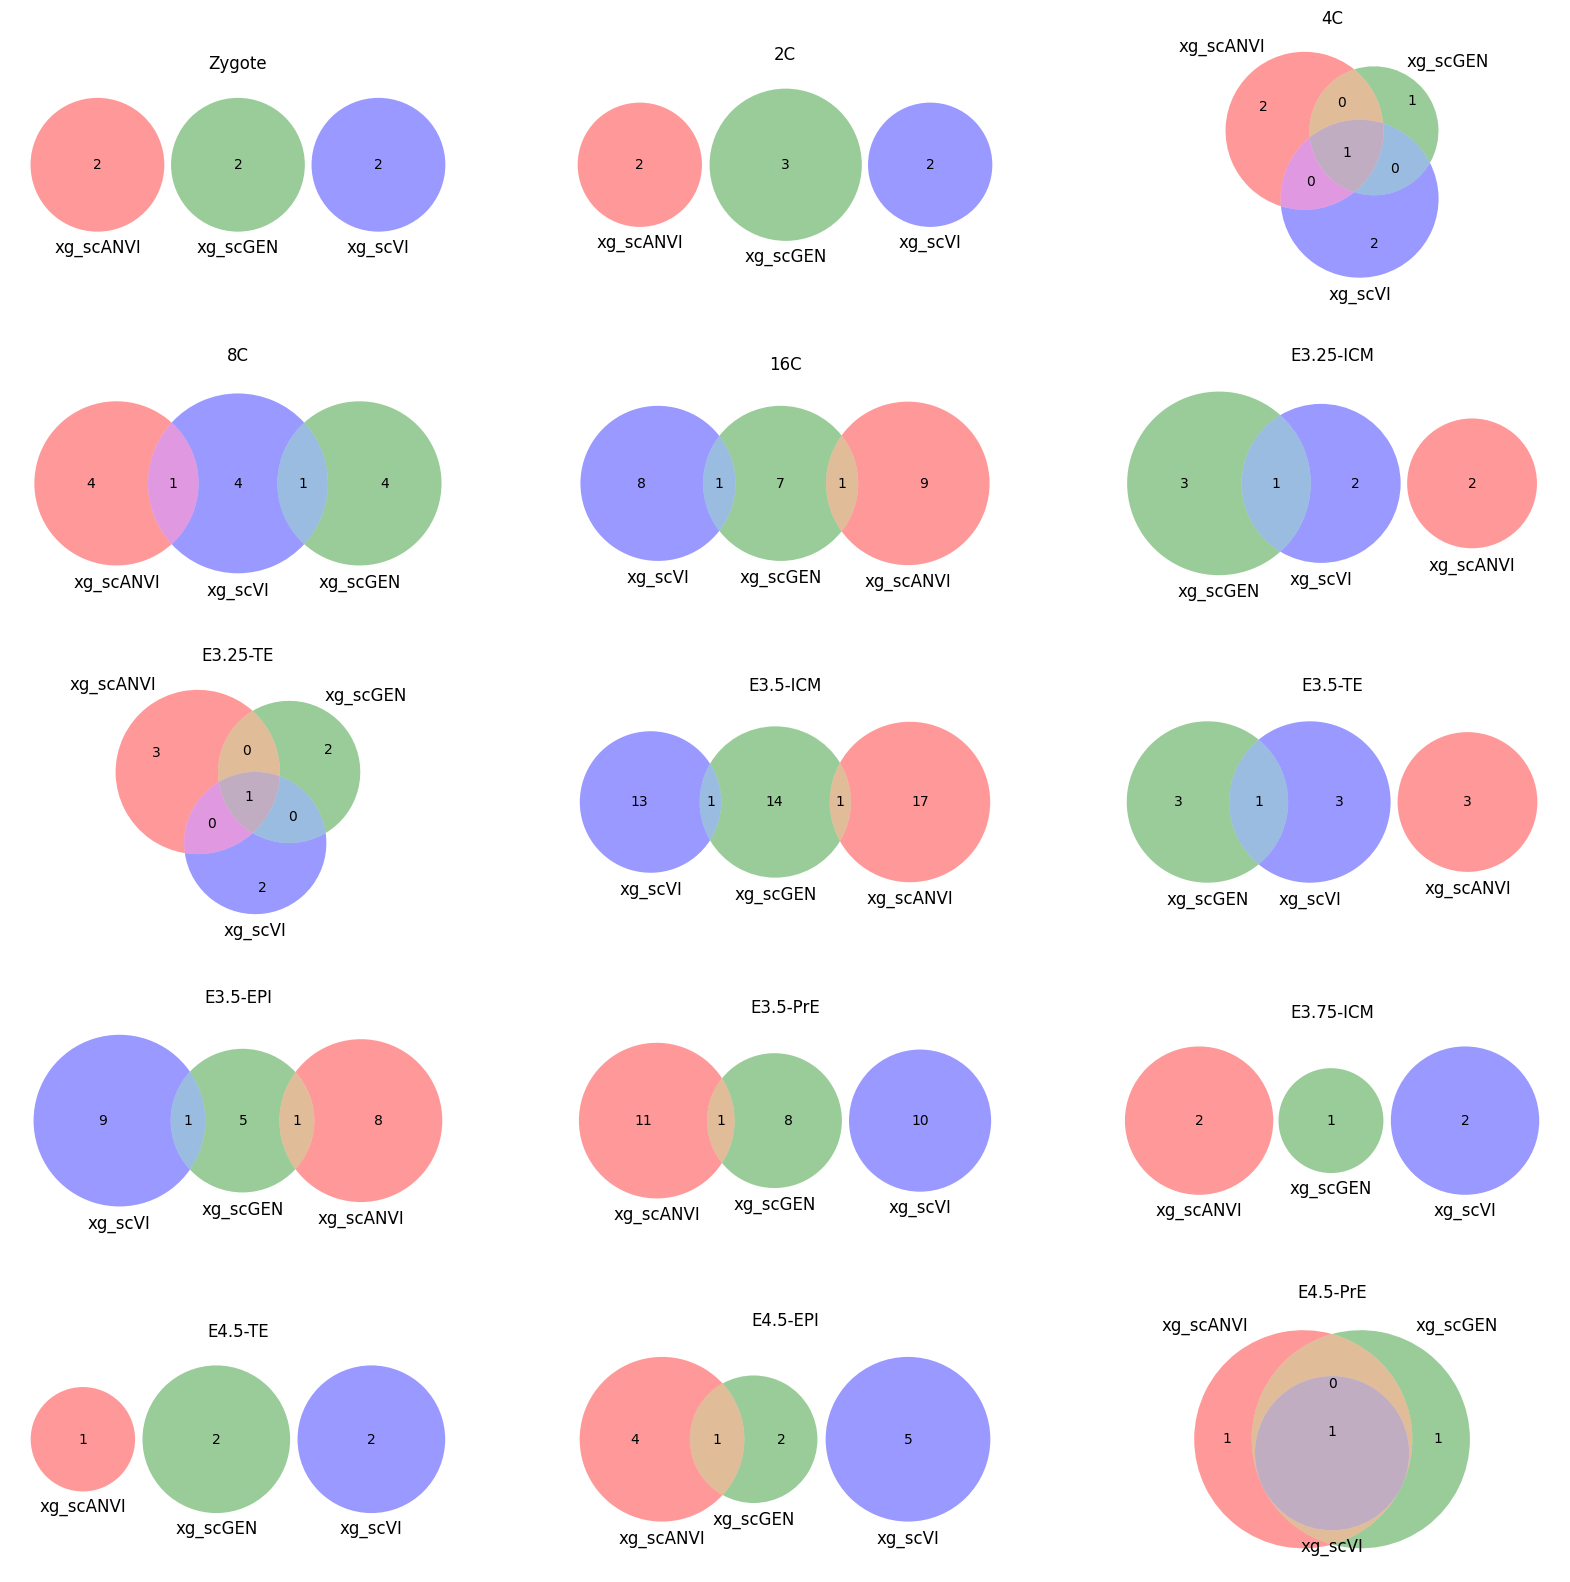

In [101]:
fig, ax = plt.subplots(5, 3, figsize=[20, 20])
for idx, ct in enumerate(mouse.obs.ct.cat.categories):
    data = xg_shaps.query('ct == @ct').groupby('clf')['feature'].apply(set)
    venn3(data.values, set_labels=data.keys(), ax=ax[idx // 3, idx % 3])
    ax[idx // 3, idx % 3].set_title(ct)

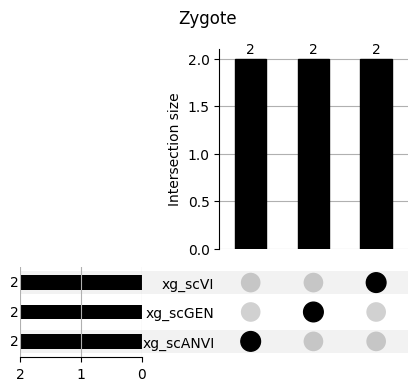

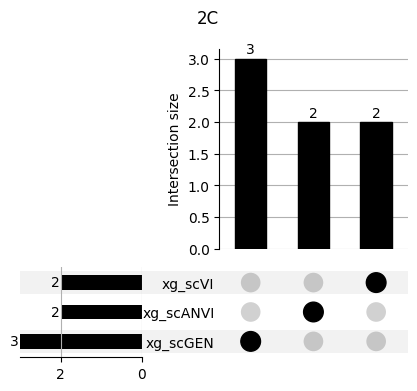

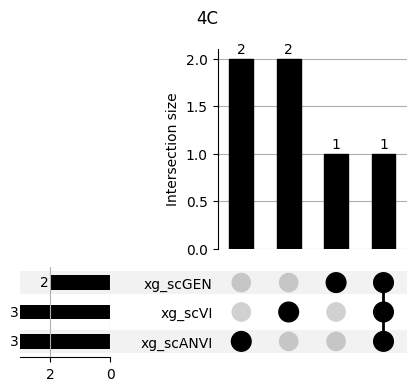

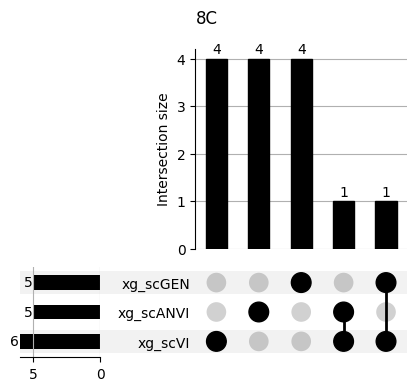

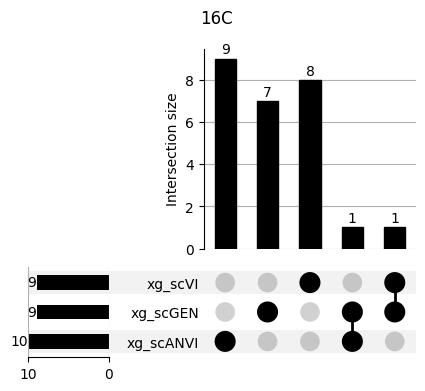

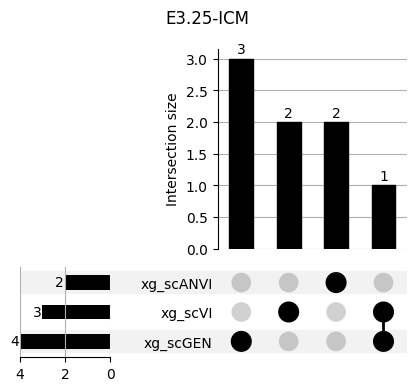

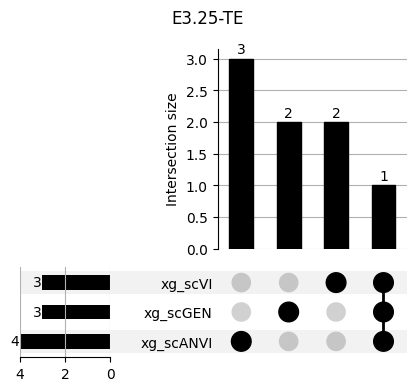

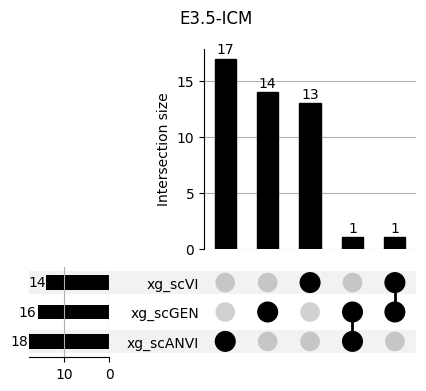

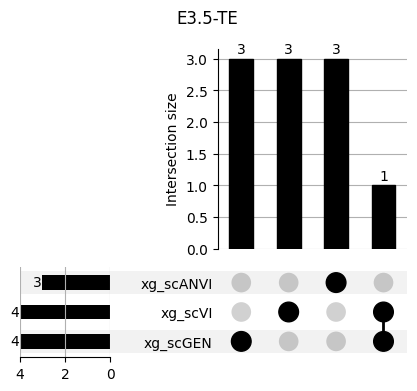

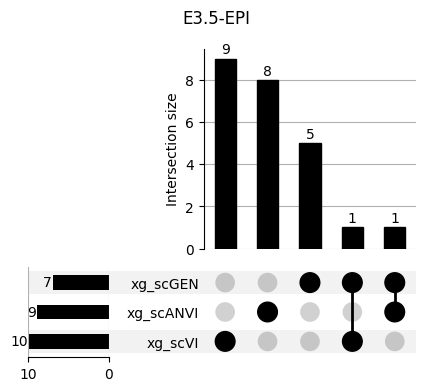

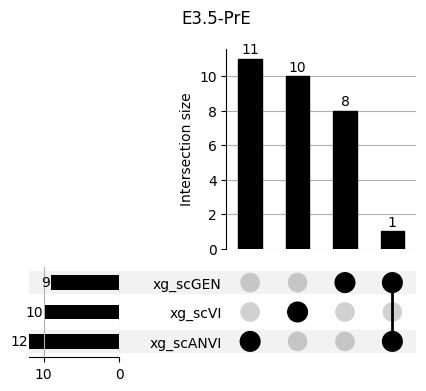

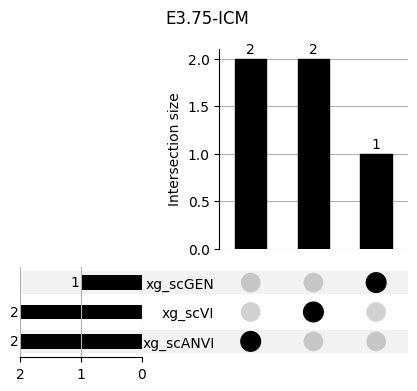

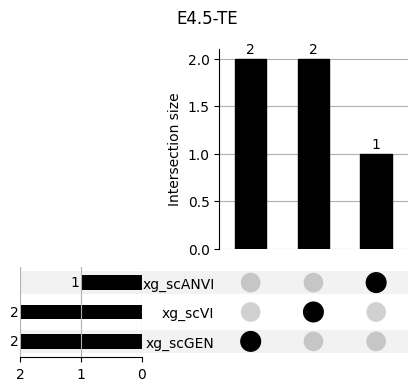

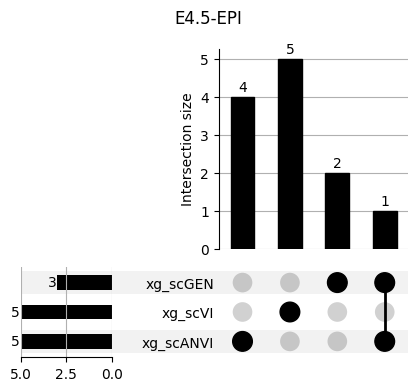

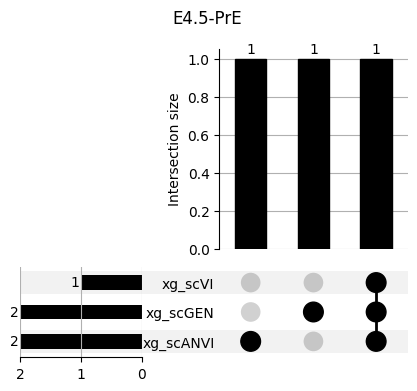

In [100]:
for ct in mouse.obs.ct.cat.categories:
    fig = plt.figure(figsize=(5, 4))
    fig.suptitle(ct)
    data = xg_shaps.query('ct == @ct').groupby('clf')['feature'].apply(set).to_dict()
    # display(data)
    _ = plot(from_contents(data), fig=fig, element_size=None, show_counts=True)

### 3.2. scANVI

In [ ]:
shap_scANVI = run_clf_scanvi(lvae, mouse, 'scANVI', n=10)
shap_scANVI.to_feather("../results/09_scanvi_shap_features_n_10.feather")

  0%|          | 0/10 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [11:10<00:00, 44.73s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [11:11<00:00, 44.76s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [11:39<00:00, 46.64s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [12:18<00:00, 49.24s/it]

 60%|█████████████████████████████████████████████████▊                                 | 9/15 [07:21<05:16, 52.72s/it]

In [165]:
shap_scANVI = pd.read_feather("../results/09_scanvi_shap_features_n_10.feather")
shap_scANVI['clf'] = 'scANVI'

In [166]:
shap_scANVI_with_xg = pd.concat([shap_scANVI, xg_shaps])

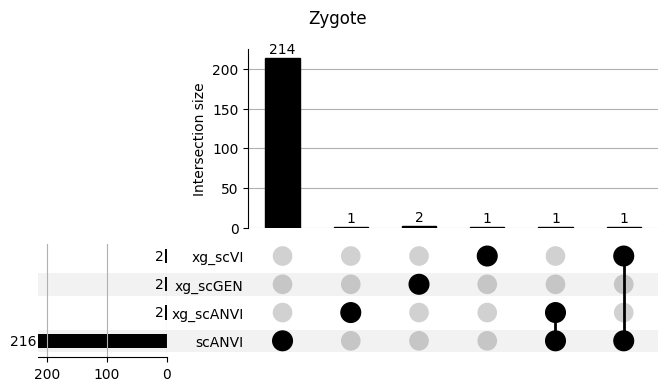

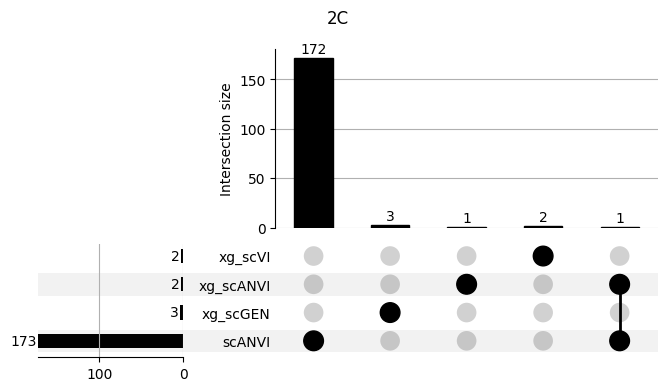

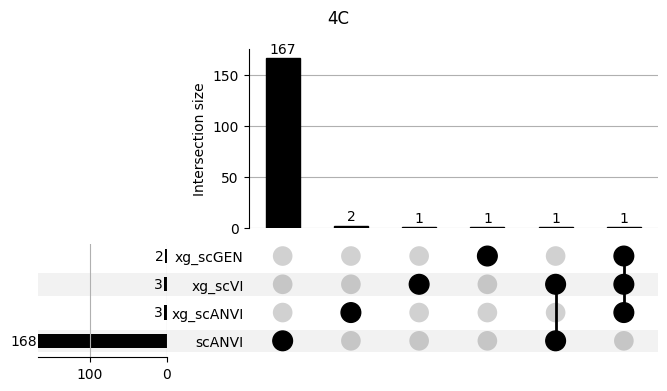

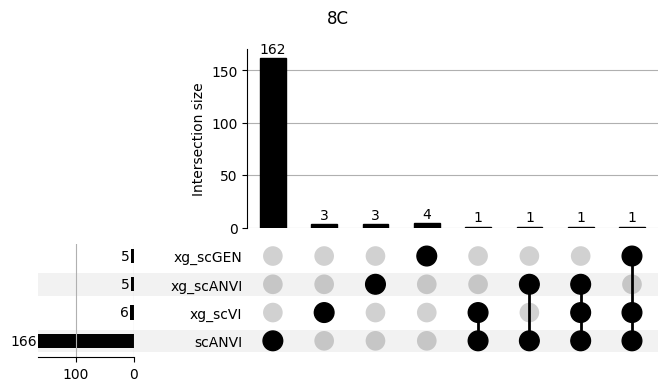

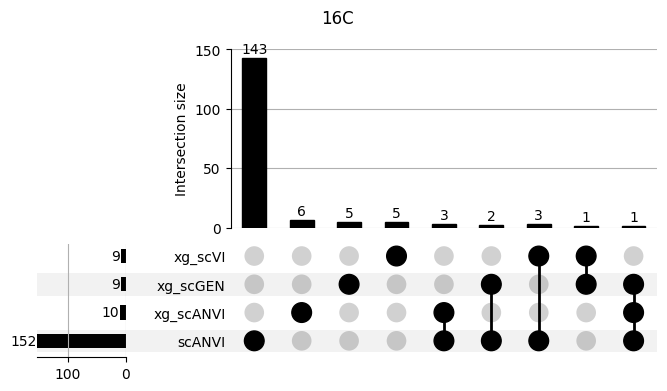

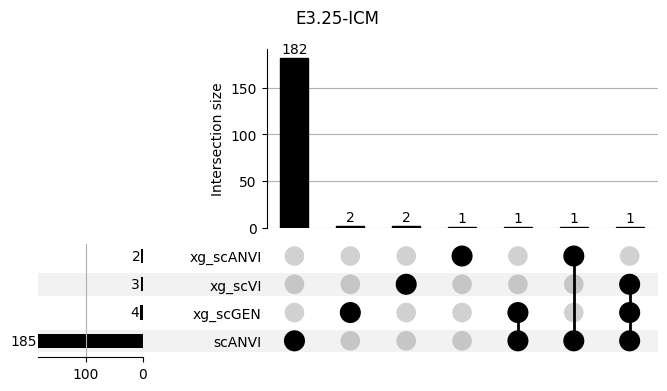

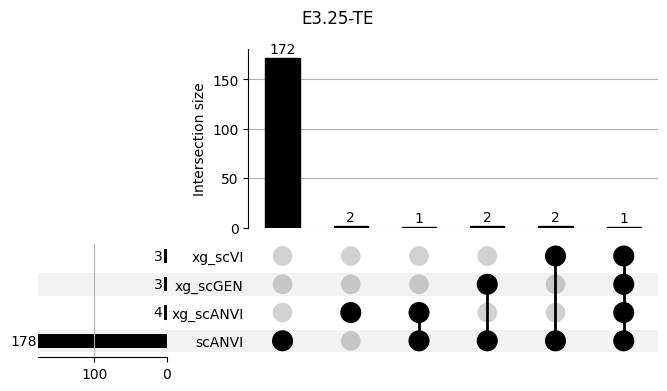

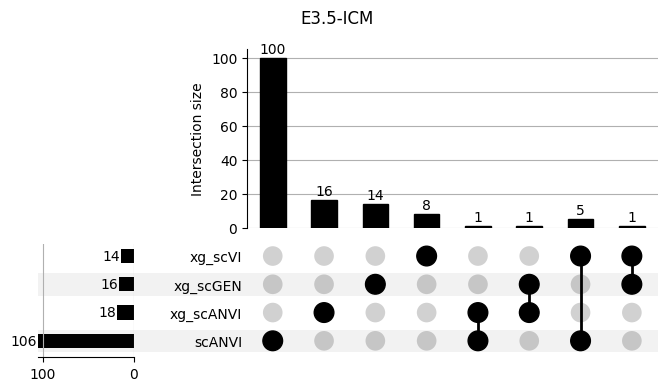

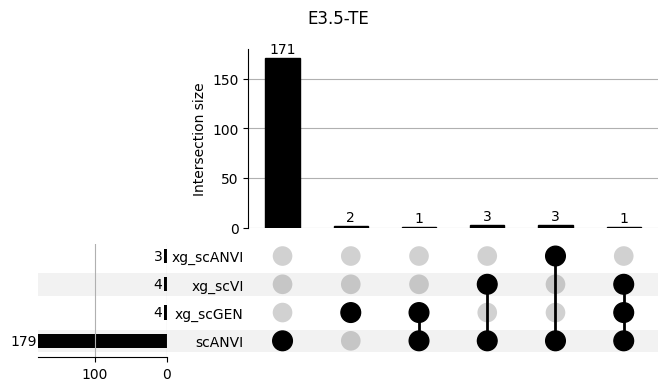

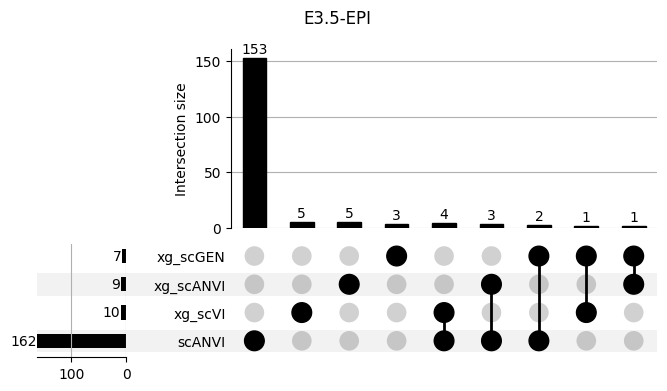

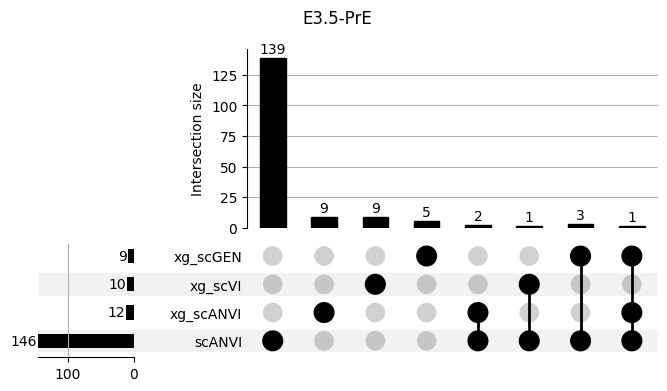

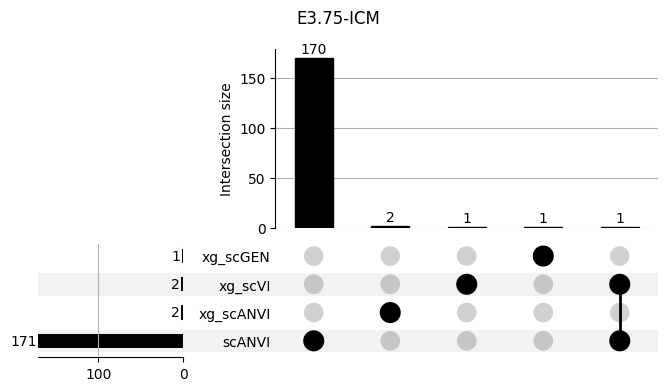

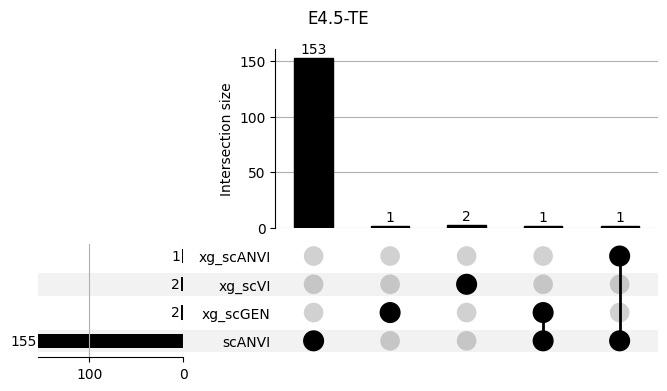

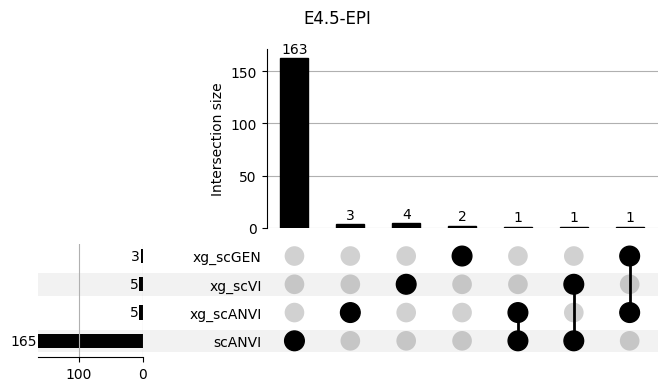

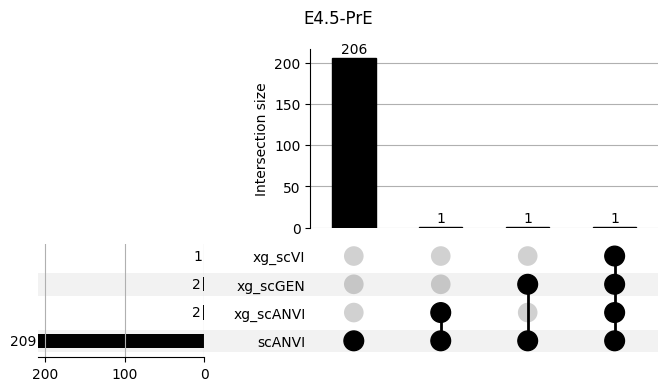

In [168]:
for ct in mouse.obs.ct.cat.categories:
    fig = plt.figure(figsize=(8, 4))
    fig.suptitle(ct)
    data = shap_scANVI_with_xg.query('ct == @ct').groupby('clf')['feature'].apply(set).to_dict()
    # display(data)
    _ = plot(from_contents(data), fig=fig, element_size=None, show_counts=True)

### 3.x. XGBoost plotting trees

In [ ]:
xg_clf.best_ntree_limit

In [ ]:
xg_clf.best_iteration

In [ ]:
xgb.plot_importance(xg_clf, max_num_features=20)

In [ ]:
xg_clf.get_booster().feature_names = mouse.var_names.tolist()

In [ ]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(xg_clf, num_trees=xg_clf.best_ntree_limit, ax=ax)
plt.show()